<a href="https://colab.research.google.com/github/jose-cano/stock-analysis/blob/main/financial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/jose-cano/stock-analysis.git
!pip3 install -r stock-analysis/requirements.txt

# Financial Analysis with the `stock_analysis` package

## Data Collection
The `StockReader` class in the `stock_analysis` package makes it easy to collect financial data, like stock market or bitcoin prices. We simply have to create an instance by specifying the date range. Then, we can grab the data:

In [2]:
import stock_analysis
import matplotlib.pyplot as plt

reader = stock_analysis.StockReader('2019-01-01', '2020-12-31')

# get faang data
fb, aapl, amzn, nflx, goog = (
    reader.get_ticker_data(ticker)
    for ticker in ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG']
)

# get S&P 500 data
sp = reader.get_index_data('S&P 500')

# get bitcoin data in USD
bitcoin = reader.get_bitcoin_data('USD')

## EDA
We can group our assets together in dataframes in order to perform EDA:

In [3]:
from stock_analysis.utils import group_stocks, describe_group

faang = group_stocks(
    {
        'Facebook': fb, 
        'Apple': aapl, 
        'Amazon': amzn, 
        'Netflix': nflx, 
        'Google': goog
    }
)

faang_sp = group_stocks(
    {
        'Facebook': fb, 
        'Apple': aapl, 
        'Amazon': amzn, 
        'Netflix': nflx, 
        'Google': goog,
        'S&P 500': sp
    }
)

all_assets = group_stocks(
    {
        'Bitcoin': bitcoin,
        'S&P 500': sp,
        'Facebook': fb, 
        'Apple': aapl, 
        'Amazon': amzn, 
        'Netflix': nflx, 
        'Google': goog
    }
)

This makes it easy to describe them all at once:

In [4]:
describe_group(all_assets).loc['close',]

name,Amazon,Apple,Bitcoin,Facebook,Google,Netflix,S&P 500
count,505.000000,505.000000,727.000000,505.000000,505.000000,505.000000,505.000000
mean,2235.904988,73.748386,9252.825408,208.146574,1335.188544,387.966593,3065.907599
std,594.306346,27.280933,4034.014685,39.665111,200.793911,78.931238,292.376435
min,1500.280029,35.547501,3399.471680,131.740005,1016.059998,254.589996,2237.399902
25%,1785.660034,50.782501,7218.593750,180.029999,1169.949951,329.089996,2870.719971
50%,1904.280029,66.730003,9137.993164,196.770004,1295.280029,364.369995,3005.469971
75%,2890.300049,91.632500,10570.513184,235.940002,1476.229980,469.959991,3276.020020
max,3531.449951,136.690002,29001.720703,303.910004,1827.989990,556.549988,3756.070068


### Visualizations
The `StockVisualizer` class makes it easy to create a variety of visualizations for financial analysis. We simply pass in the dataframe of the asset we want to visualize:

In [5]:
netflix_viz = stock_analysis.StockVisualizer(nflx)

We can use the moving average to smooth out the trend for the stock. Notice that, in the shaded region, the 90-day moving average is acting like a ceiling for the stock price:

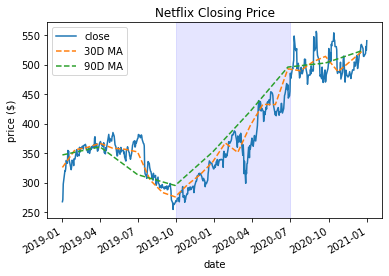

In [6]:
ax = netflix_viz.moving_average('close', ['30D', '90D'])
netflix_viz.shade_region(
    ax, x=('2019-10-01', '2020-07-01'), color='blue', alpha=0.1
)
ax.set(title='Netflix Closing Price', ylabel='price ($)')
plt.show()

Often, the **exponentially weighted moving average (EWMA)** can provide a better trend
since we can put additional emphasis on more recent values. Let's see how exponential 
smoothing looks for our data:

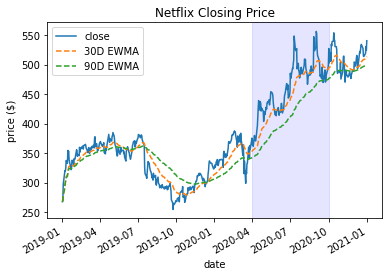

In [7]:
ax = netflix_viz.exp_smoothing('close', [30,90])
netflix_viz.shade_region(
    ax, x=('2020-04-01', '2020-10-01'),
    color='blue', alpha=0.1
)
ax.set(title='Netflix Closing Price', ylabel='price ($)')
plt.show()

The 90-day EWMA appears to be acting as the support level in the shaded region.

We can also visualize the effect of after hour trades. We can see that Netflix had a rough third quarter in 2019 in terms of after-hours trades:

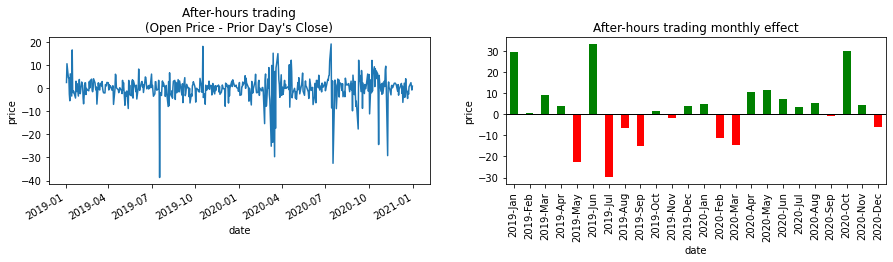

In [8]:
netflix_viz.after_hours_trades()
plt.show()

We can use **candlestick plots** to study the OHLC data. Let's create one for Netflix, along 
with a bar plot for volume traded, by using the candlestick() method. We will also 
resample the data into 2-week intervals to improve the visibility of the candlesticks. When the body of the candlestick is white, it means that 
the stock gained value. Note that, for the most part, the spikes in volume traded were 
accompanied by increases in stock value:

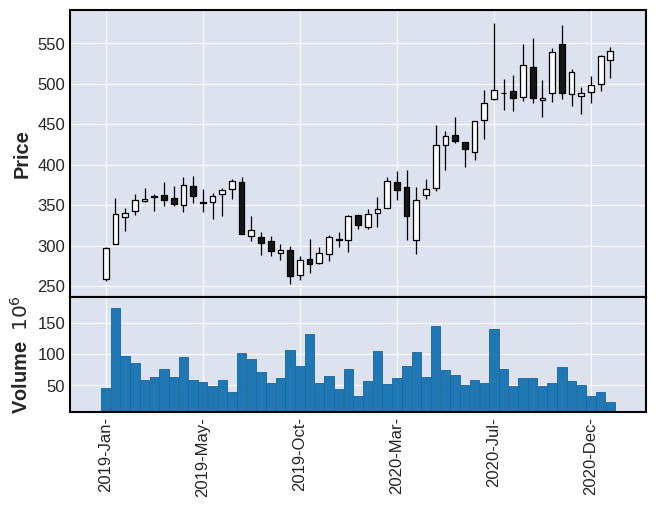

In [9]:
netflix_viz.candlestick(
    resample='2W', volume=True, xrotation=90,
    datetime_format="%Y-%b-"
)
plt.show()

We can use jointplot() method to see how Netflix compares to the S&P 500. If we take a look at the plot, they appear to be weakly positively correlated. With financial 
analysis, we can calculate a metric called **beta** that indicates an asset's correlation to an 
index, such as the S&P 500.

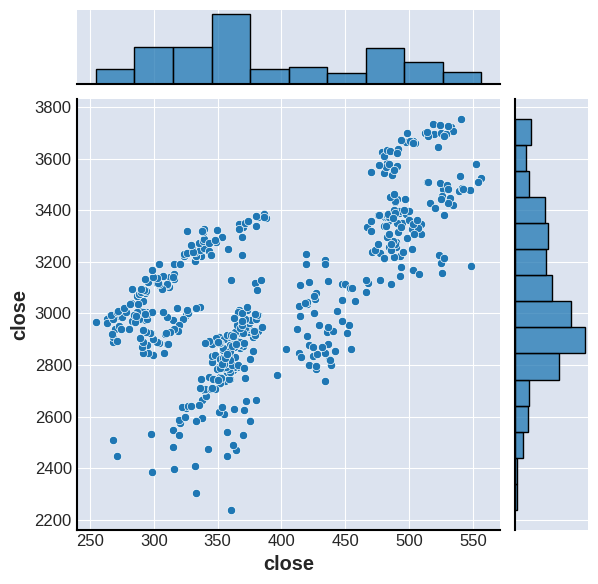

In [10]:
netflix_viz.jointplot(sp, 'close')
plt.show()

We can use the correlation_heatmap() method to visualize the correlations 
between Netflix and Amazon as a heatmap, using the daily percentage change of each 
of the columns. Netflix and Amazon are weakly positively correlated, but only on the OHLC data:

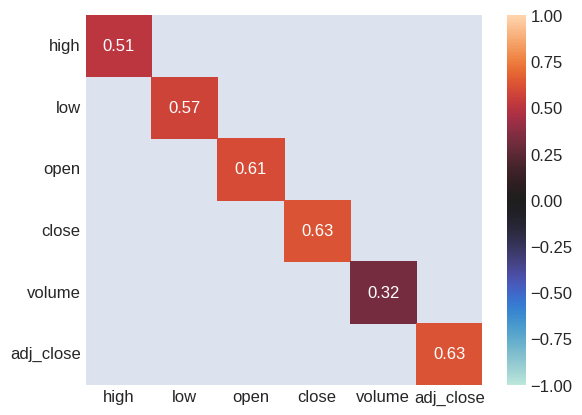

In [11]:
netflix_viz.correlation_heatmap(amzn)
plt.show()

We can use the fill_between_other() method to compare Netflix's stock price over time to another asset. Notice that the shaded region shrinks in height as it approaches the reference line—this 
is the difference between the values in Netflix stock and Tesla stock decreasing over time. 
On November 11, 2020, as Tesla overtakes Netflix, the shaded region changes in color 
(from green to red) and begins to increase in height as Tesla widens the gap:

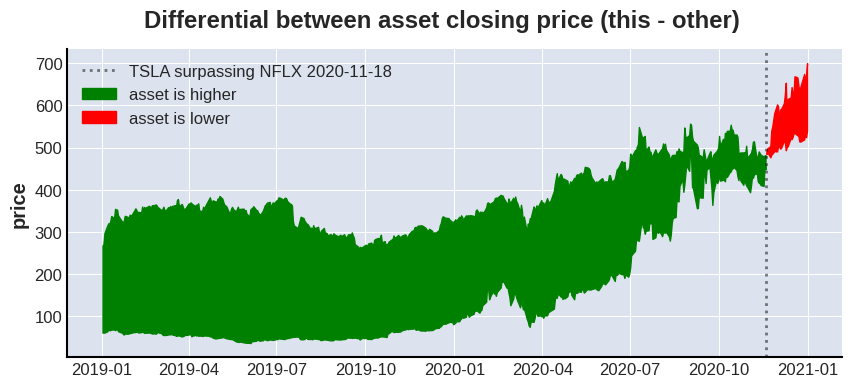

In [12]:
tsla = reader.get_ticker_data('TSLA')
change_date = (tsla.close > nflx.close).idxmax()
ax = netflix_viz.fill_between_other(tsla)
netflix_viz.add_reference_line(
    ax, 
    x=change_date, 
    color='k', 
    linestyle=':', 
    label=f'TSLA surpassing NFLX {change_date:%Y-%m-%d}',
    alpha=0.5
)
plt.show()

If we want to visualize groups of assets, we use the AssetGroupVisualizer class. Let's look at the correlations between the assets using percentage change:

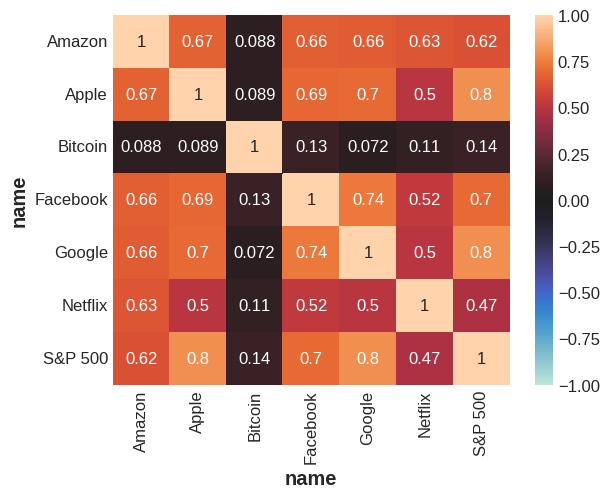

In [13]:
all_assets_viz = stock_analysis.AssetGroupVisualizer(all_assets)
all_assets_viz.heatmap()
plt.show()

Bitcoin is on a much larger scale so we have to use subplots to compare it to the stock market.

In [15]:
import matplotlib as mpl
mpl.rcdefaults()

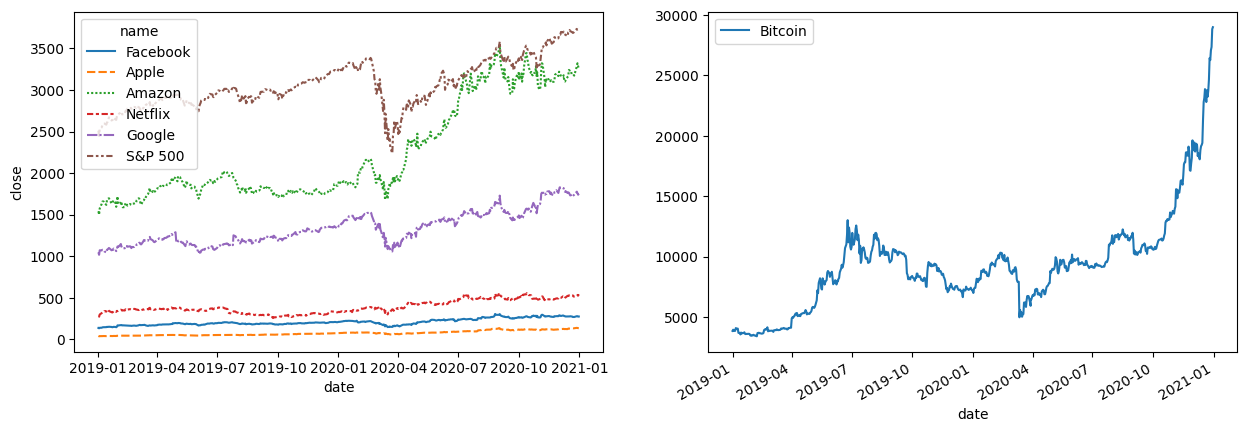

In [16]:
faang_sp_viz = stock_analysis.AssetGroupVisualizer(faang_sp)
bitcoin_viz = stock_analysis.StockVisualizer(bitcoin)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
faang_sp_viz.evolution_over_time('close', ax=axes[0], style=faang_sp_viz.group_by)
bitcoin_viz.evolution_over_time('close', ax=axes[1], label='Bitcoin')
plt.show()

We can view the effect that after-hours trading had on each of the FAANG stocks:

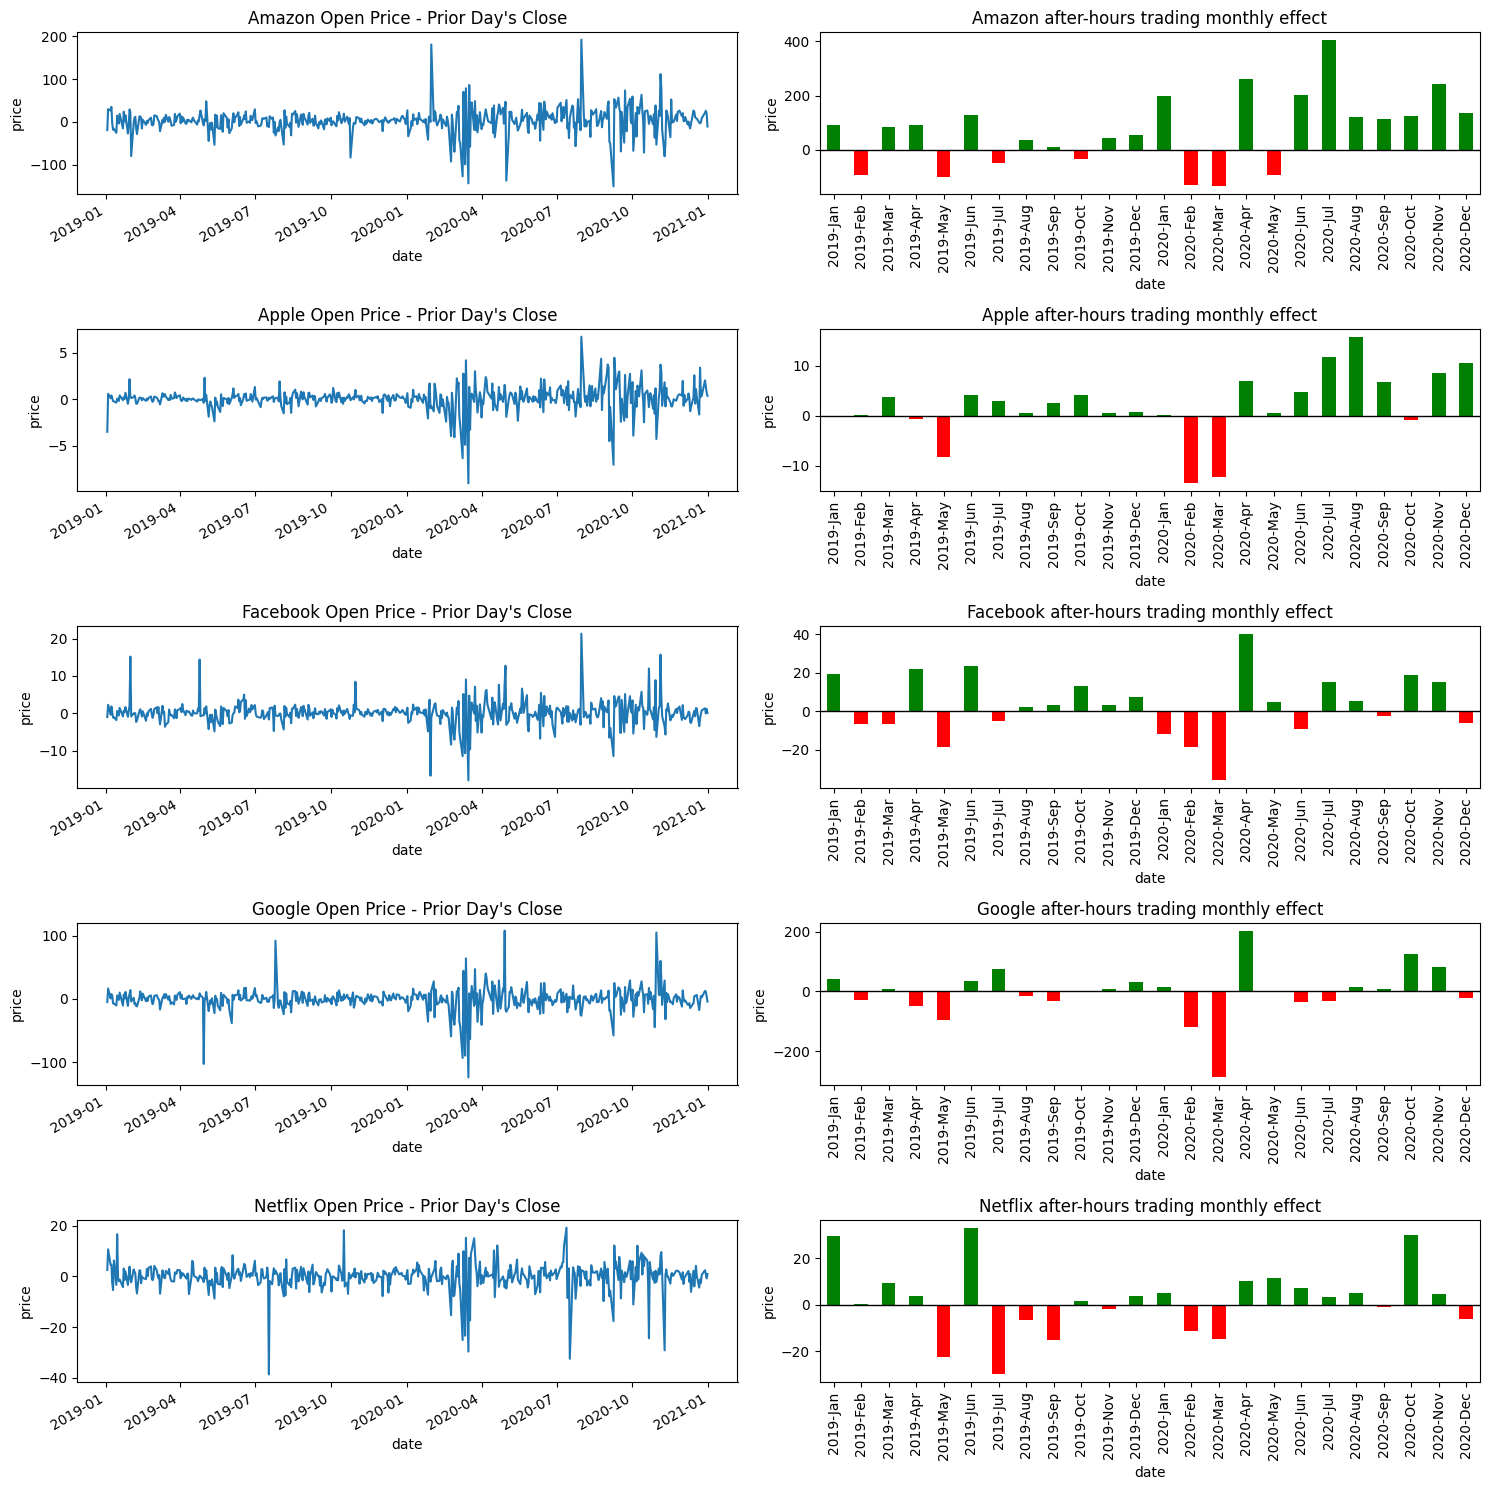

In [17]:
faang_viz = stock_analysis.AssetGroupVisualizer(faang)
faang_viz.after_hours_trades()
plt.show()

We can look at what the exponentially smoothed moving averages look like for all FAANG stocks as well:

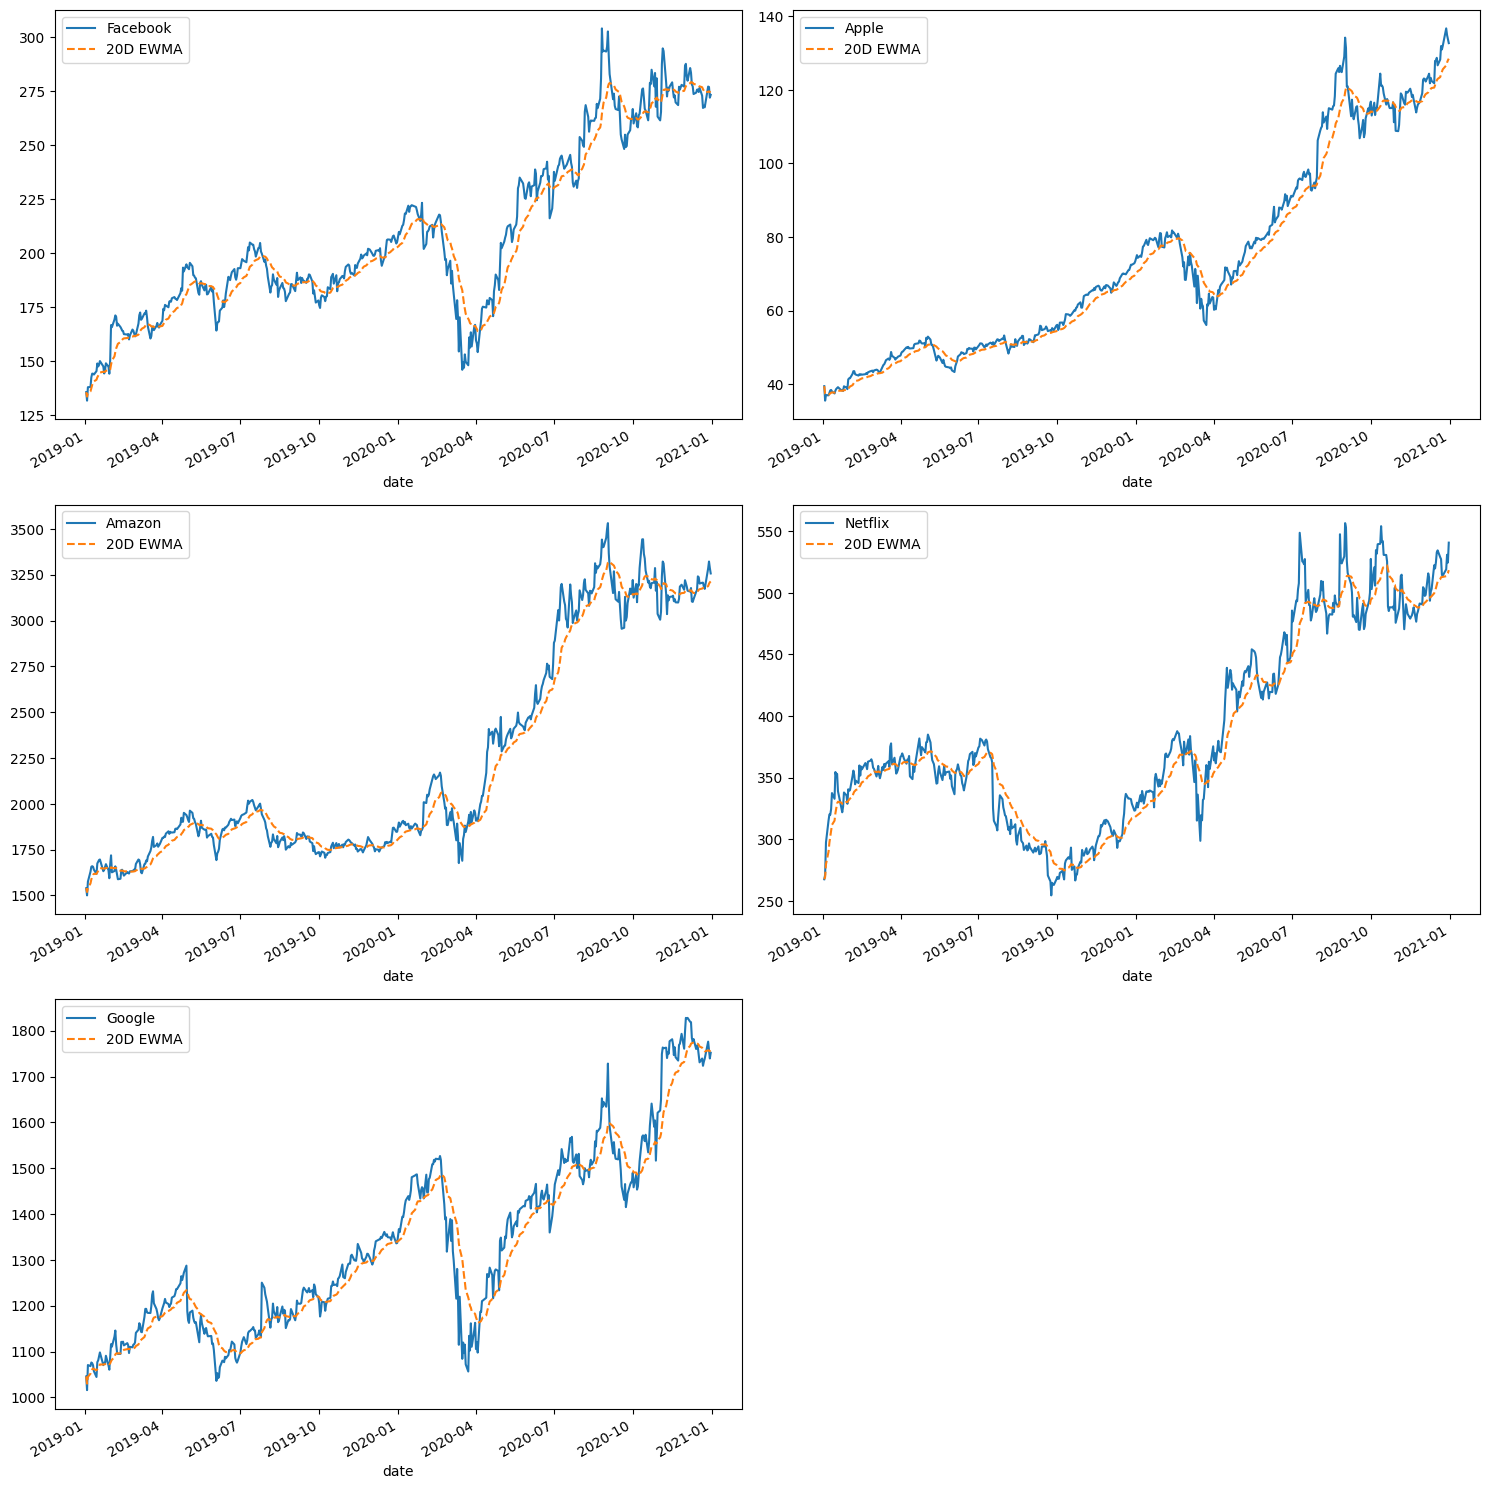

In [19]:
faang_viz.exp_smoothing('close', 20)
plt.show()

With short windows, both these smoothing methods perform similarly:

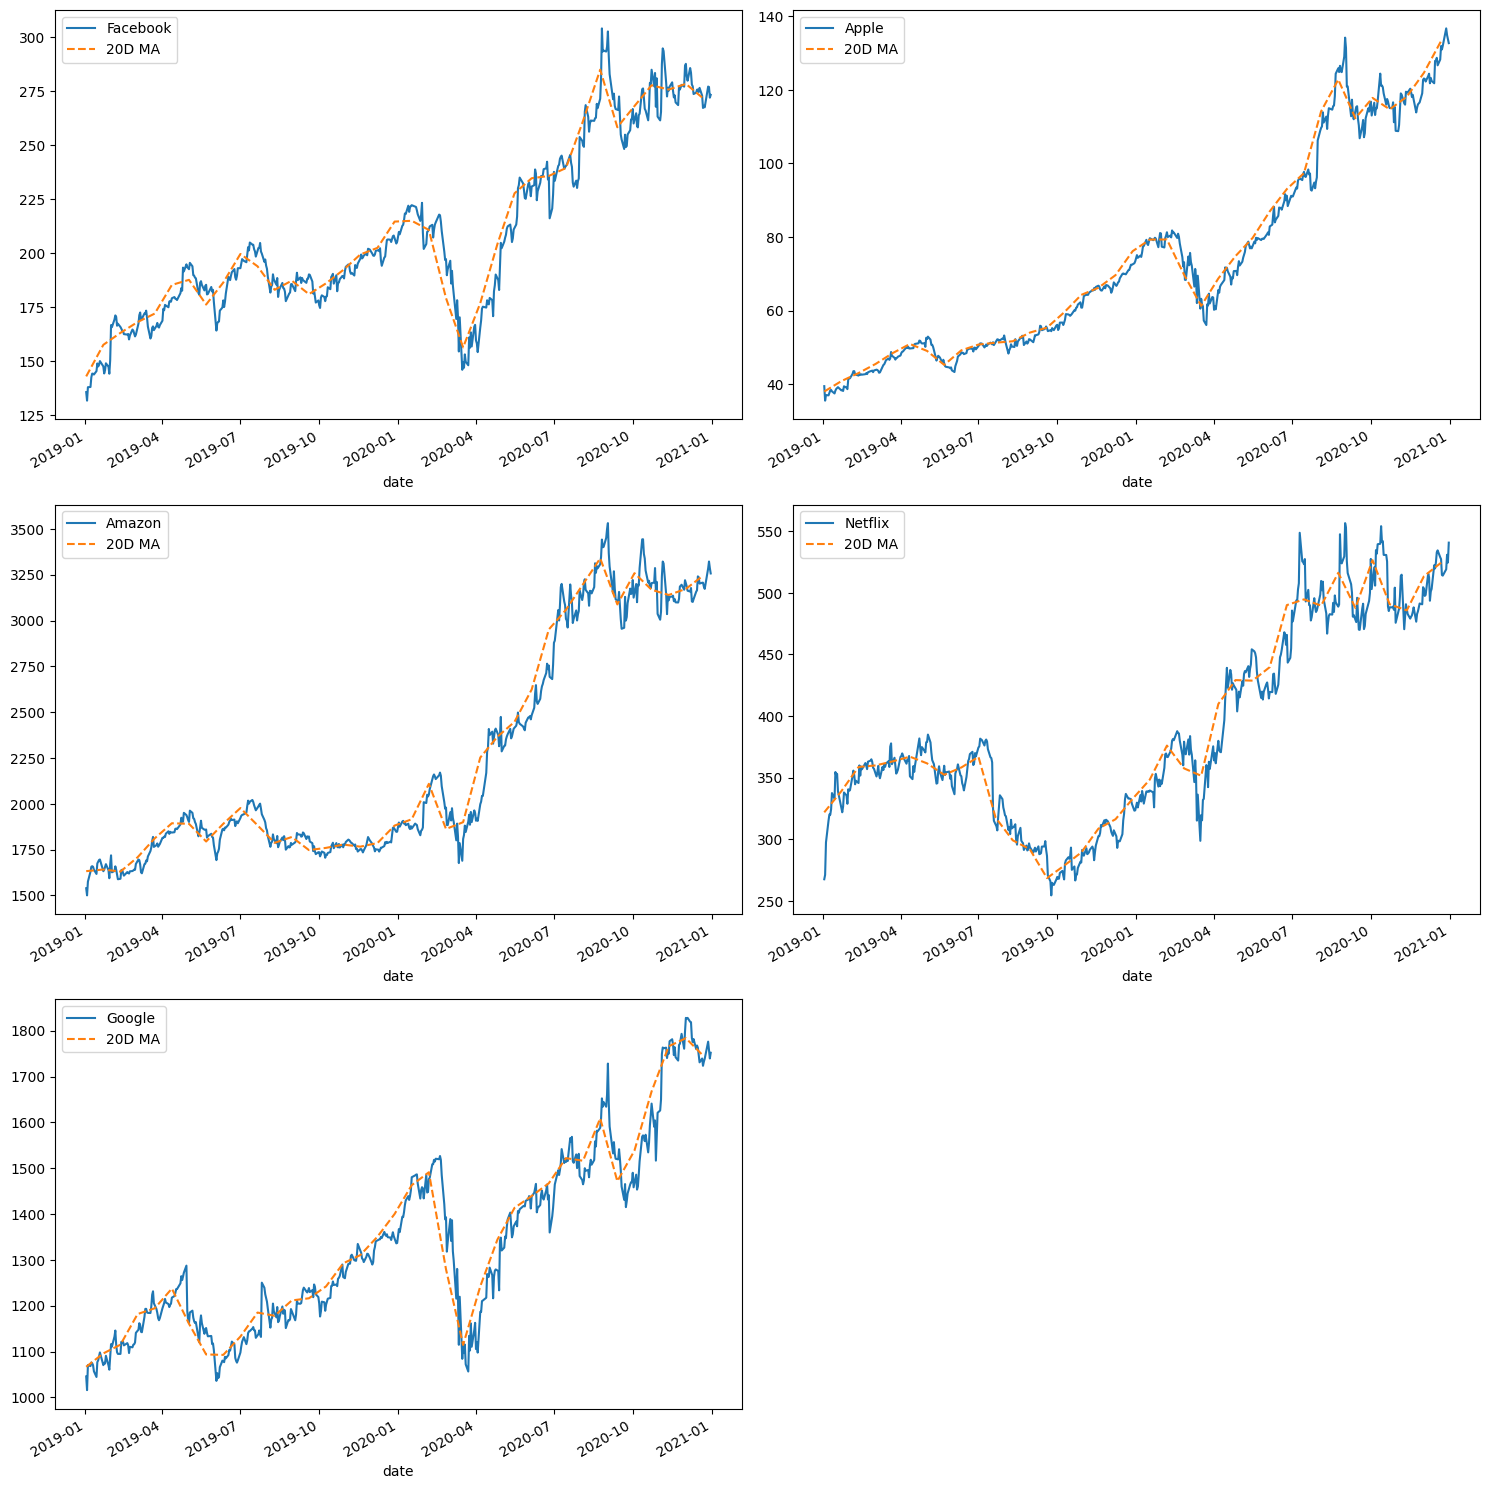

In [21]:
faang_viz.moving_average('close', '20D')
plt.show()

The distributions of closing price across the FAANG stocks are quite different:

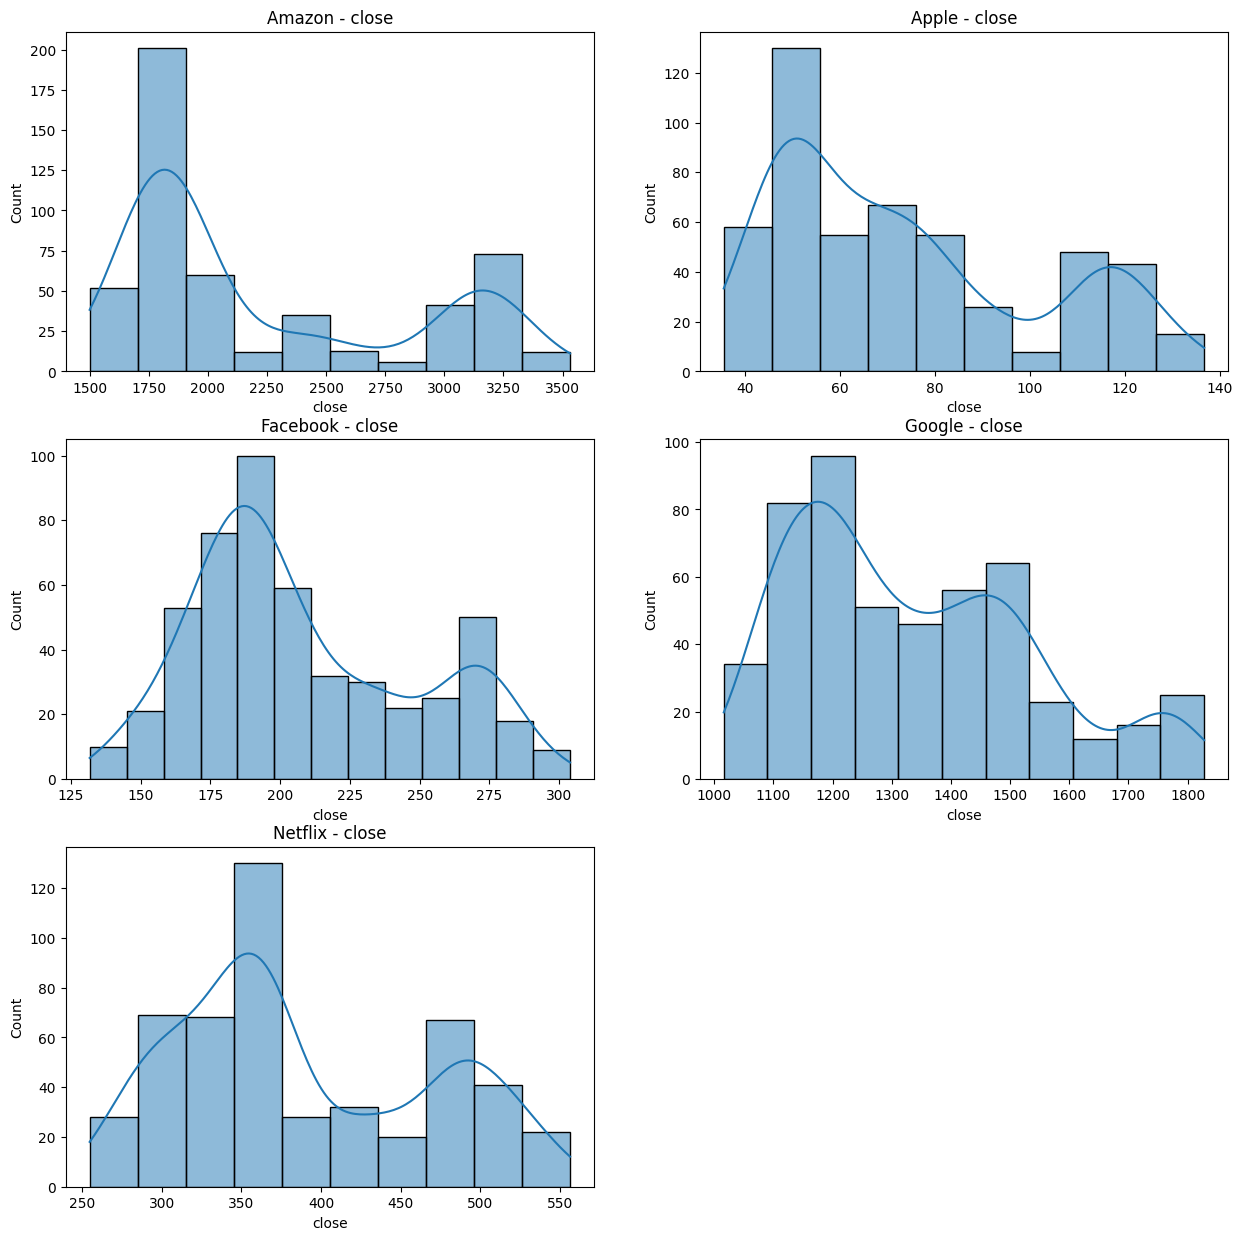

In [22]:
faang_viz.histogram('close')
plt.show()

Viewing box plots we can easily see that Google and Amazon are on a much larger scale:

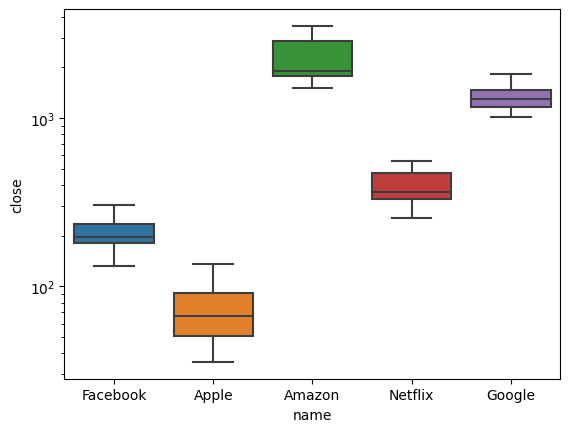

In [23]:
faang_viz.boxplot('close')
plt.yscale('log')
plt.show()

Correlations between the stocks are weak:

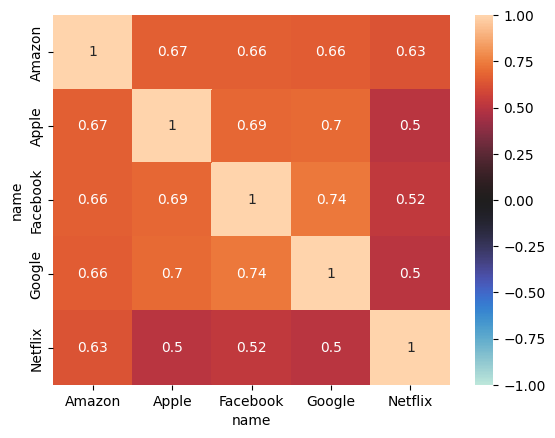

In [25]:
faang_viz.heatmap()
plt.show()

We can view this information as scatter plots as well:

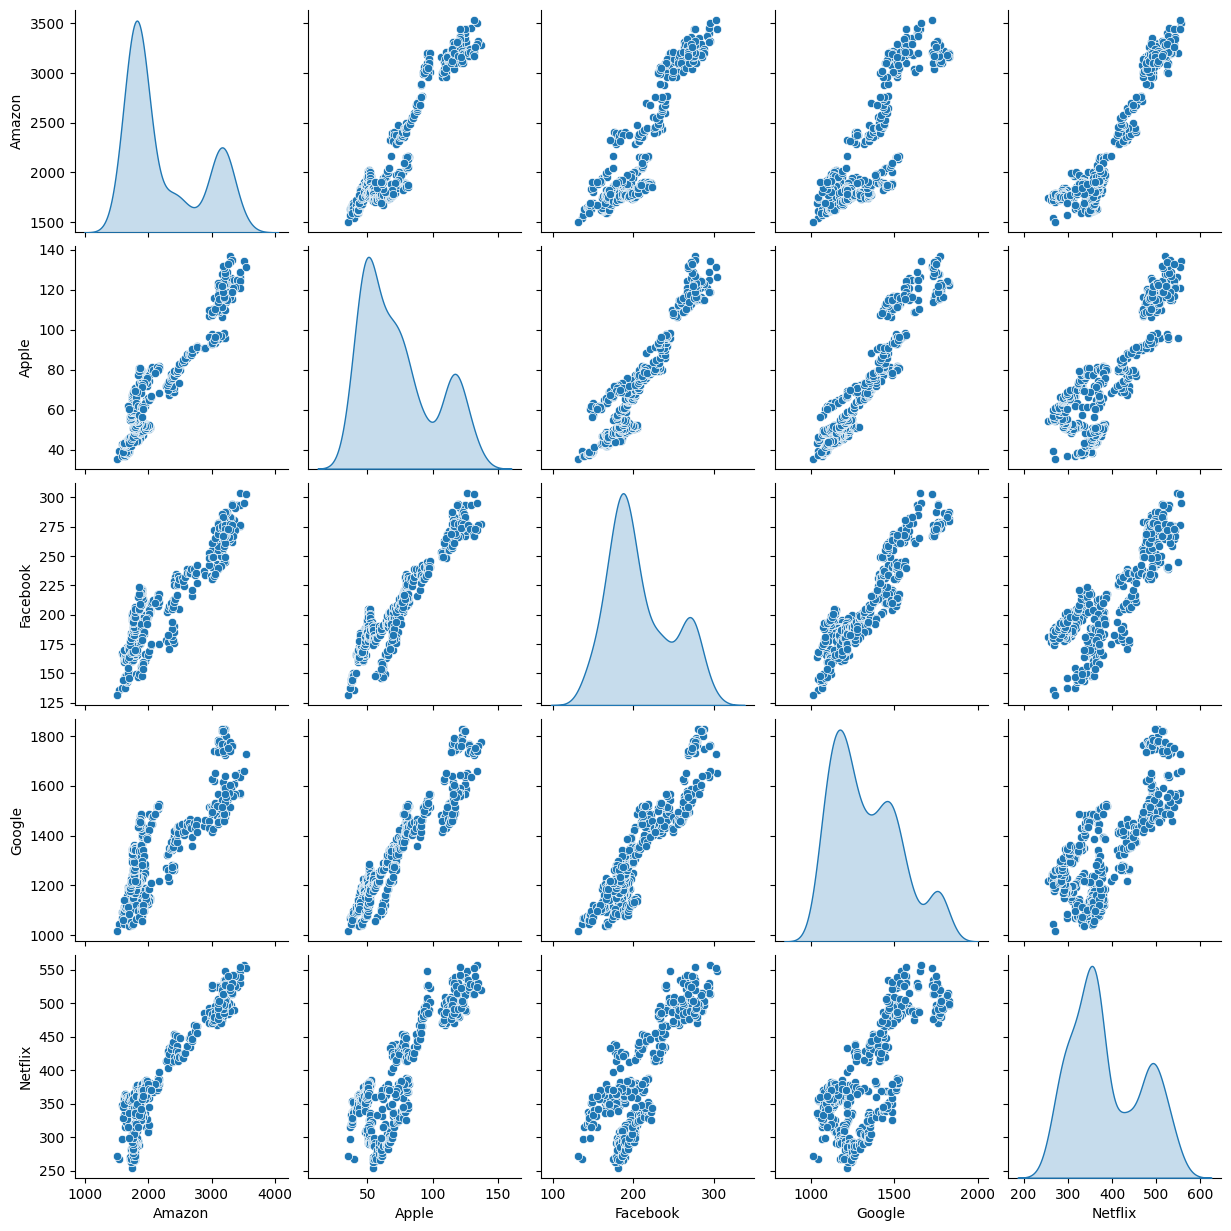

In [28]:
faang_viz.pairplot()
plt.show()

## Technical Analysis
Technical analysis involves looking at metrics to understand the peformance of an asset.
### Single Asset
We can use the `StockAnalyzer` class to calculate metrics for us:

In [29]:
nflx_analyzer = stock_analysis.StockAnalyzer(nflx)

One such metric is annualized volatility:

In [30]:
nflx_analyzer.annualized_volatility()

0.4626772090887299

### Asset Groups
When working with groups, we use the `AssetGroupAnalyzer` class:

In [31]:
all_assets_analyzer = stock_analysis.AssetGroupAnalyzer(all_assets)

####Coefficient of Variation
We can check how large the standard deviation is in terms of the mean of the stock price as another way to look at volatility. This shows that bitcoin is the most volatile:

In [32]:
all_assets_analyzer.analyze('cv')

{'Amazon': 0.2658012522278963,
 'Apple': 0.36991905161737615,
 'Bitcoin': 0.43597652683008137,
 'Facebook': 0.19056336194852783,
 'Google': 0.1503861849732808,
 'Netflix': 0.2034485433043269,
 'S&P 500': 0.09536374658108934}

#### Annualized Volatility

Percent change daily can be used to calculate the annualized volatility. This involves 
calculating the standard deviations of percent change over the last year and multiplying it 
by the square root of the number of trading days in the year (the code assumes 252). By 
using percent change, large changes in price (relative to the asset's price) will be penalized 
more severely. Using annualized volatility, Facebook looks much more volatile compared 
to when we used the CV (although still not the most volatile)

In [33]:
all_assets_analyzer.analyze('annualized_volatility')

{'Amazon': 0.38510990770417824,
 'Apple': 0.4670809643500884,
 'Bitcoin': 0.4635140114227396,
 'Facebook': 0.45943066572169544,
 'Google': 0.3833720603377728,
 'Netflix': 0.4626772090887299,
 'S&P 500': 0.34491195196047}

#### Bull Market
We can check if the assets are in a bull market, meaning their value increased $\geq$ 20% in the last 2 months:

In [34]:
all_assets_analyzer.analyze('is_bull_market')

{'Amazon': False,
 'Apple': True,
 'Bitcoin': True,
 'Facebook': False,
 'Google': False,
 'Netflix': False,
 'S&P 500': False}

#### Bear Market
We can check if the assets are in a bear market, meaning their value dropped $\geq$ 20% in the last 2 months:

In [35]:
all_assets_analyzer.analyze('is_bear_market')

{'Amazon': False,
 'Apple': False,
 'Bitcoin': False,
 'Facebook': False,
 'Google': False,
 'Netflix': False,
 'S&P 500': False}

#### Beta
Beta tells us how an asset's performance correlates to a market index. A beta of 1 with the S&P 500 means the asset moves with the S&P 500. Notice bitcoin is below one because it is a different type of asset.

In [36]:
all_assets_analyzer.analyze('beta', index=sp)

{'Amazon': 0.7563691182389212,
 'Apple': 1.1732735011059165,
 'Bitcoin': 0.37160242824833595,
 'Facebook': 1.0245928218547513,
 'Google': 0.9862076250402392,
 'Netflix': 0.7408228073823278,
 'S&P 500': 0.999999999999999}

#### Alpha
Alpha allows us to compare the returns of an asset to an index. We can compare to the S&P 500 using the risk-free rate of return. You can look up rates [here](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/TextView.aspx?data=yield) or use the `StockReader.get_risk_free_rate_of_return()` method. This shows that bitcoin much higher returns than the S&P 500 (due to scale) and Apple is the top performer among the FAANG stocks:

In [37]:
r_f = reader.get_risk_free_rate_of_return()
all_assets_analyzer.analyze('alpha', index=sp, r_f=r_f)

{'Amazon': 0.7383391908270169,
 'Apple': 1.7801122522388664,
 'Bitcoin': 6.355297988074054,
 'Facebook': 0.5048625273190839,
 'Google': 0.1853719782424813,
 'Netflix': 0.6500392764754639,
 'S&P 500': 4.996003610813204e-16}

#### Cumulative Returns
Cumulative returns show us what we would have made for a dollar investment at time period 0. This can be multiplied by the actual investment to get the return:

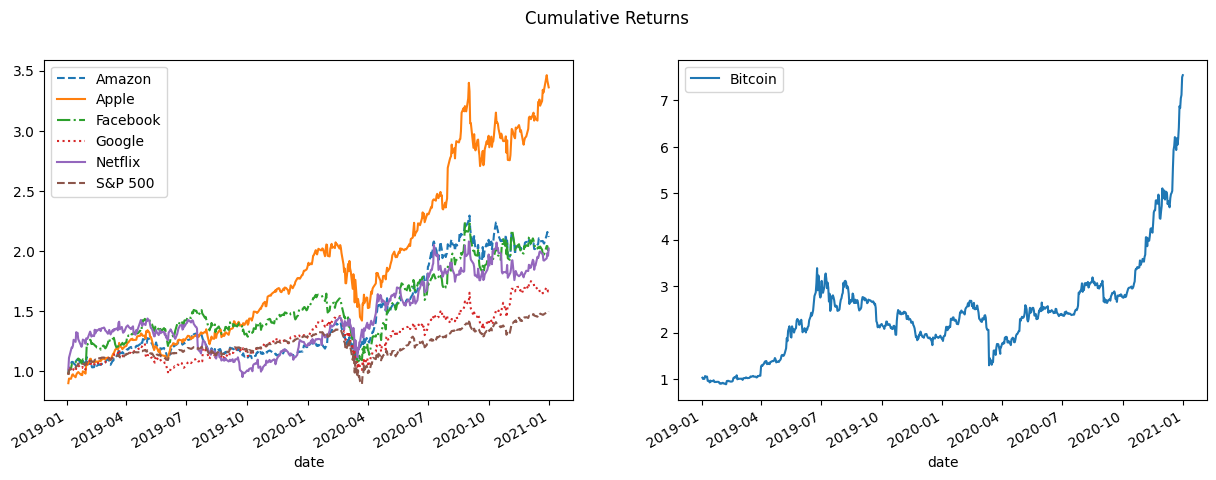

In [38]:
from cycler import cycler

viz_cycler = (
    cycler(color=[plt.get_cmap('tab10')(x/10) for x in range(10)])
    + cycler(linestyle=['dashed', 'solid', 'dashdot', 'dotted', 'solid'] * 2)
)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].set_prop_cycle(viz_cycler)
cumulative_returns = all_assets_analyzer.analyze('cumulative_returns')

for name, data in cumulative_returns.items():
    data.plot(
        ax=axes[1] if name == 'Bitcoin' else axes[0], 
        label=name,
        legend=True
    )
fig.suptitle('Cumulative Returns')
plt.show()

Despite the struggles in early 2020, all of the assets gained value. Notice that the bitcoin 
subplot's y-axis goes from 0 to 7 (right subplot), while the stock market subplot (left) 
covers half of that range.

## Modeling
For modeling tasks, we can use the `StockModeler` class:

In [39]:
from stock_analysis import StockModeler

### Time Series Decomposition
We can decompose the Netflix time series into its trend, seasonality component, and residuals:

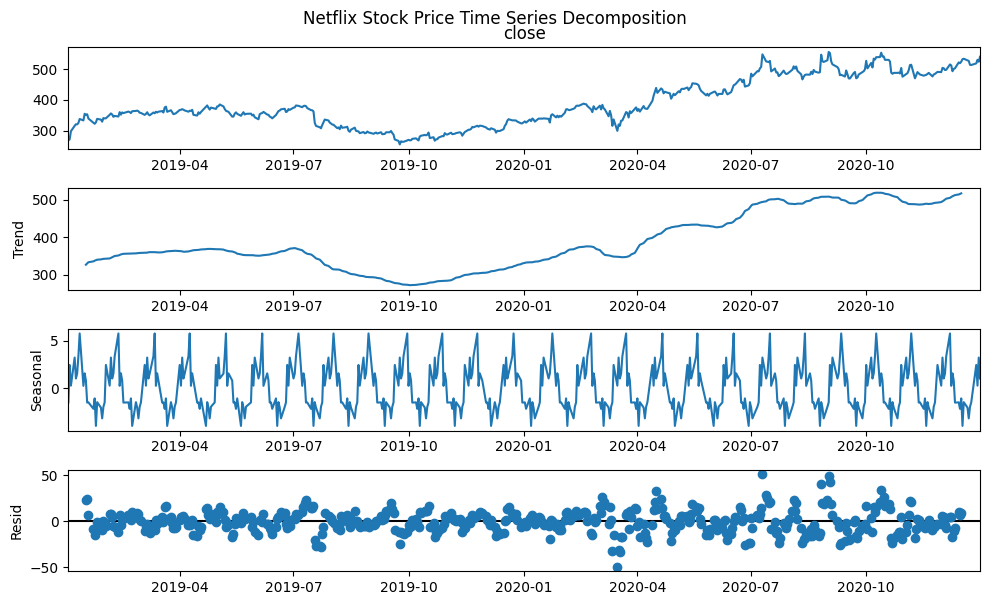

In [40]:
decomposition = StockModeler.decompose(nflx, 20) # 20 period frequency
fig = decomposition.plot()
fig.suptitle('Netflix Stock Price Time Series Decomposition', y=1)
fig.set_figheight(6)
fig.set_figwidth(10)
fig.tight_layout()

For more complicated models, we could decompose and then build our model around 
the components.

### ARIMA
We can use ARIMA to model the performance with autoregressive (AR), differences or lagged data (I), and moving average (MA) terms. The autocorrelation plot can help find a good starting point for this:

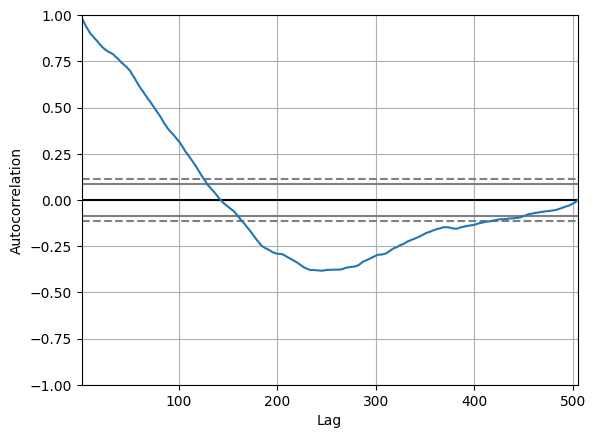

In [42]:
# we can use autocorrelation plots to find a good starting point for ARIMA
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(nflx.close)
plt.show()

Lag plots can also be helpful.

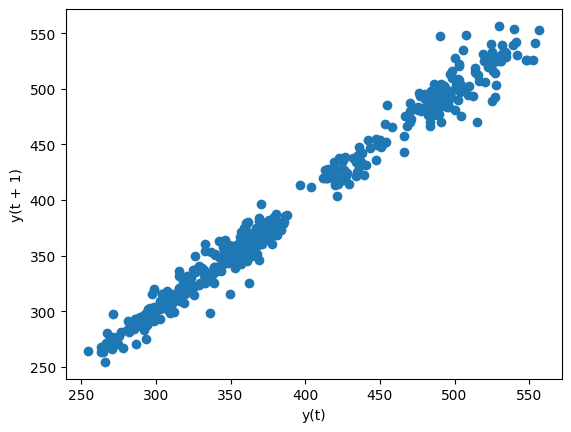

In [43]:
from pandas.plotting import lag_plot
lag_plot(nflx.close)
plt.show()

ARIMA takes a long time to train, so we will start with an AR of 10.

In [45]:
# this takes a long time to run, so we will start with a smaller AR of 10
%%capture
arima_model = StockModeler.arima(nflx, ar=10, i=1, ma=5)

The summary() method shows statistics on the model's performance:

In [46]:
# AR = 10, I = 1, MA = 5
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  522
Model:                ARIMA(10, 1, 5)   Log Likelihood               -1925.959
Date:                Wed, 20 Oct 2021   AIC                           3883.917
Time:                        19:16:07   BIC                           3952.009
Sample:                    01-02-2019   HQIC                          3910.589
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1400      0.275     -0.510      0.610      -0.679       0.398
ar.L2          0.1033      0.241      0.429      0.668      -0.369       0.575
ar.L3         -0.2914      0.204     -1.426      0.1

A simpler way of analyzing the model is to look at the residuals, or 
the discrepancy between the observed values and predictions made by the model. The 
residuals should have a mean of 0 (right subplot) and have equal variance throughout (left subplot), meaning that 
they should not depend on the independent variable (which is the date, in this case). 
The latter requirement is referred to as **homoskedasticity**; when this assumption is not 
met, the estimates given by the model are not optimal.

The residuals appear to be normally distributed (right subplot); however, their variance appears to depend on time (left subplot), so this may not be a good model:

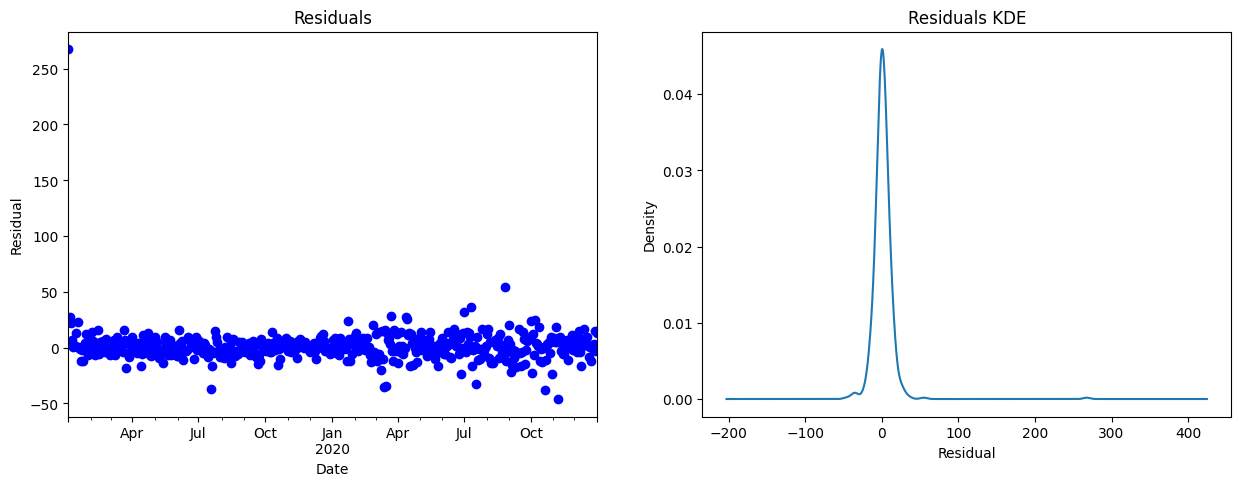

In [48]:
StockModeler.plot_residuals(arima_model)
plt.show()

When we looked at the model summary, statsmodels ran 
a statistical test for heteroskedasticity using the default significance level of 
0.05. The value of the test statistic is labeled **Heteroskedasticity** (H) and the 
p-value is labeled Prob(H) (two-sided). Note that the result was statistically 
significant (the p-value was less than or equal to the significance level), 
meaning it's very unlikely that our residuals are homoskedastic.

### Linear Regression
We can build a linear regression using the last value to determine the next value:

In [49]:
X, Y, lm = StockModeler.regression(nflx)
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:                  close   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          7.470e+05
Date:                Wed, 20 Oct 2021   Prob (F-statistic):                        0.00
Time:                        19:32:48   Log-Likelihood:                         -1889.3
No. Observations:                 504   AIC:                                      3781.
Df Residuals:                     503   BIC:                                      3785.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The adjusted R2 makes this model look very good since it is near 1; however, 
we know that this is simply because stock data is highly autocorrelated, so let's look at the residuals. Once again, the residuals appear to depend on time, so this model also suffers from heteroskedasticity:

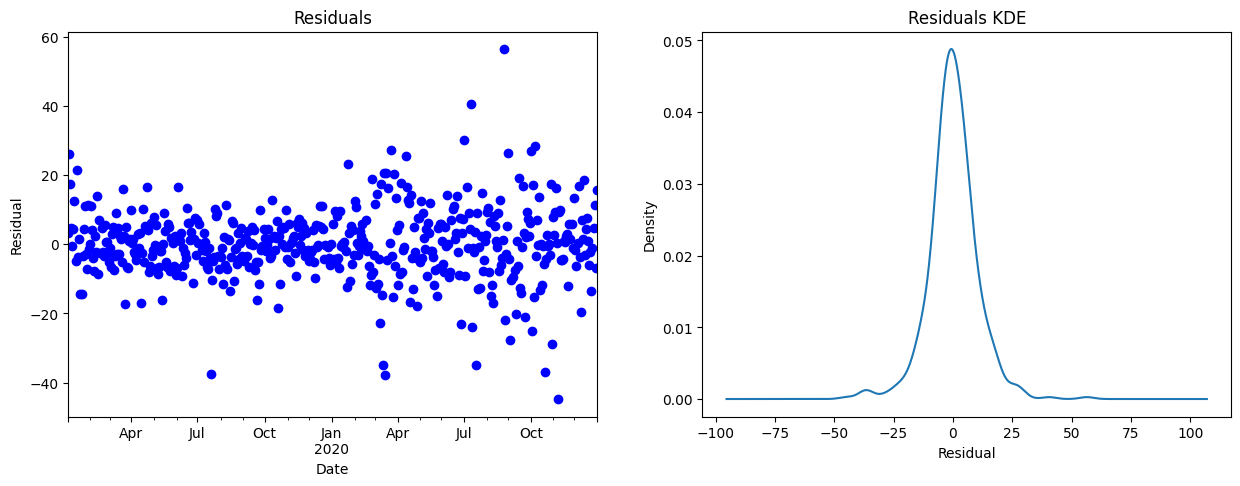

In [51]:
StockModeler.plot_residuals(lm)
plt.show()

### Compare Models Against Actuals
Let's see how these models compared to what actually happened:

Text(0, 0.5, 'price ($)')

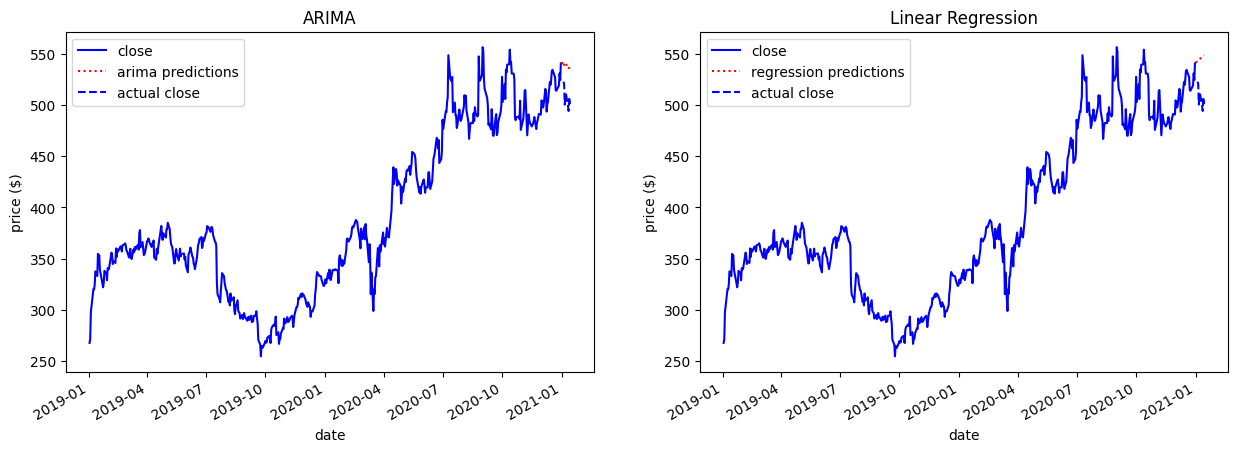

In [52]:
import datetime as dt

start = dt.date(2021, 1, 1)
end = dt.date(2021, 1, 14)

jan = stock_analysis.StockReader(start, end).get_ticker_data('NFLX')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

arima_ax = StockModeler.arima_predictions(
    nflx, arima_model, start=start, end=end,
    ax=axes[0], title='ARIMA', color='b'
)
jan.close.plot(ax=arima_ax, style='b--', label='actual close')
arima_ax.legend()
arima_ax.set_ylabel('price ($)')

linear_reg = StockModeler.regression_predictions(
    nflx, lm, start=start, end=end,
    ax=axes[1], title='Linear Regression', color='b'
)
jan.close.plot(ax=linear_reg, style='b--', label='actual close')
linear_reg.legend()
linear_reg.set_ylabel('price ($)')

The ARIMA model's predictions look more in line with the pattern we would expect, but, 
given the unpredictable nature of the stock market, both models are far off from what 
actually happened in the first two weeks of January 2021.

As we can see, forecasting stock performance is not easy, even for a few days. There is a 
lot of data that is not being captured by these models, such as news stories, regulations, 
and changes in management, to name a few. No matter how well a model appears to 
fit, be weary of trusting predictions as these will be extrapolations, and there is a lot of 
randomness not being accounted for.
To further illustrate this, take a look at the following set of plots that have been generated 
using random walks and stock data.

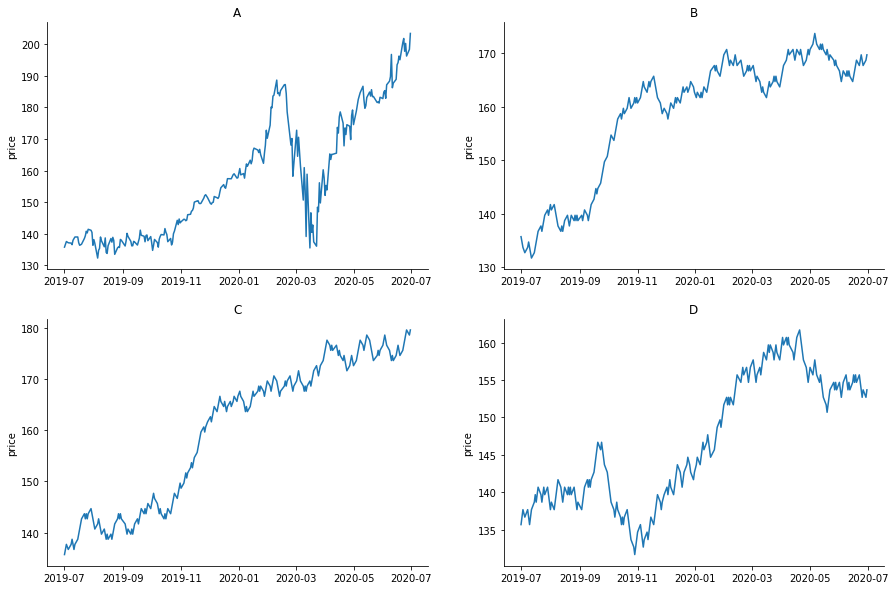

In [ ]:
msft = stock_analysis.StockReader('2019-07-01', '2020-06-30').get_ticker_data('MSFT')
real_stock, axes = finance_viz.random_walk_stock_comparison(msft, probs=[0.45, 0.55])
plt.show()

Each of these time series originates at the same point (Microsoft's closing price on July 1, 2019), but only A is real stock data—B, C, and D are all random walks. Hard 
(or impossible) to tell, right?